# CIFAR-10 Example with Custom CNN

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. For this exercise, the dataset is subset to 5000 training and 1000 validation.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

Here are the classes in the dataset, as well as 10 random images from each: 

<img src='https://drive.google.com/uc?id=1tsF12lE9IIW8BVFZgeEgMQIBG_nvWCXY' alt="CFIAR-10" width=500>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset

from torchvision import transforms, datasets, models

import ssl # maybe necessary to avoid ssl certificate error
ssl._create_default_https_context = ssl._create_unverified_context

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import seaborn as sns

## Load the internal data from `torchvision.datasets`

In [2]:
train_data = datasets.CIFAR10(root = '.data', train = True, download=True, transform = transforms.ToTensor())
test_data  = datasets.CIFAR10(root = '.data', train = False, download=True, transform = transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [3]:
class_names = train_data.class_to_idx
print(class_names)
class_idx_to_names = dict([(j,i) for i,j in class_names.items()])
print(class_idx_to_names)

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


Subset to 5000 training and 1000 testing

In [4]:
np.random.seed(500)
train_idx = np.random.choice(len(train_data), round(len(train_data)*0.1), replace=False)
test_idx = np.random.choice(len(test_data), round(len(test_data)*0.1), replace=False)

train_data = Subset(train_data, train_idx)
test_data = Subset(test_data, test_idx)

print(train_data)
print(len(train_data))

print(test_data)
print(len(test_data))

5000
1000


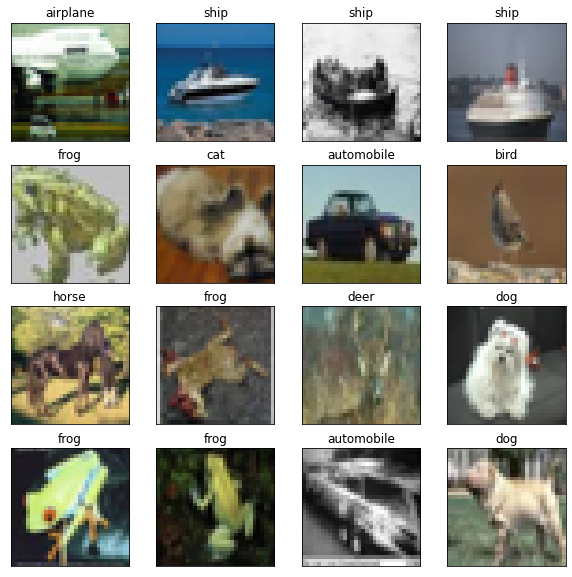

In [5]:
def img_plotter(img_list, lab_list):
    ncols = 4
    nrows = int(np.ceil(len(img_list)/ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2.5,nrows*2.5))
    for i in range(len(img_list)):
        image = img_list[i]
        label = lab_list[i]
        ax = axes.flat[i]
        if len(image.shape) == 3:
            ax.imshow(np.transpose(image.numpy(), (1, 2, 0)))
        else:
            ax.imshow(image.numpy())
        ax.set_title(label)
        ax.set_xticks([])
        ax.set_yticks([])

# View the first few images
count = 0
img_list = []
lab_list = []
for image, label in train_data:
    img_list.append(image)
    lab_list.append(class_idx_to_names[label])
    count += 1
    if count >= 16:
        break

img_plotter(img_list, lab_list)

## Pre-process the data

Since the images already have standardized sizes, this step will only do normalization and random changes.

In [6]:
# Find the mean and standard deviation of the training data
image_mean = []
image_szs  = []

for image, label in DataLoader(train_data, batch_size=1, shuffle=False):
    image_mean.append(image.mean(dim=[0,2,3])) # the first dimension is batch size
    image_szs .append(tuple(image.size()[2:]))

means = torch.stack(image_mean).mean(dim = 0)
stds  = torch.stack(image_mean).std (dim = 0)

print(f'Mean values of each channel: {means}')
print(f'Mean values of each channel: {stds }')

Mean values of each channel: tensor([0.4916, 0.4831, 0.4491])
Mean values of each channel: tensor([0.1267, 0.1240, 0.1513])


In [7]:
# Re-load the data with transformations
# - transforms.RandomRotation: randomly rotate within (min,max) or +/-degrees range
# - transforms.RandomHorizontalFlip: randomly horizontal flip with given probability
# - transforms.RandomCrop: crop the image to given size, and optionally pad the edge of the image
train_transforms = transforms.Compose([
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(32, padding=2),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=means,
                                                std=stds)
                       ])
test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=means,
                                                std=stds)
                       ])


torch.manual_seed(999)

train_data = datasets.CIFAR10('./data', train=True, download=True,
                              transform=train_transforms)
test_data = datasets.CIFAR10('./data', train=False, download=True,
                             transform=test_transforms)

# subset again
train_data = Subset(train_data, train_idx)
test_data = Subset(test_data, test_idx)

batch_size = 10
train_iterator = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_iterator = DataLoader(test_data, shuffle=False, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
for i,(img_list, lab_list) in enumerate(train_iterator):
  break

print(img_list.shape, img_list.dtype)
print(lab_list.shape, img_list.dtype)

torch.Size([10, 3, 32, 32]) torch.float32
torch.Size([10]) torch.float32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

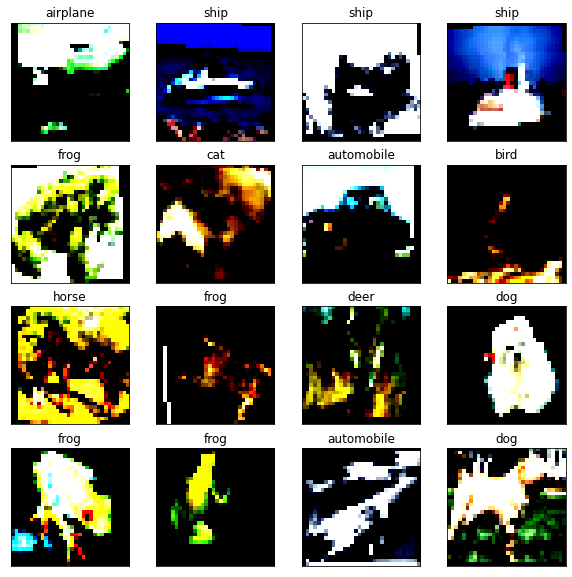

In [9]:
# RView the first few images after transformation
# Note the warnings occur because the normalization causes the values of image 
#   pixels to be out of the range of [0,1]. matplotlib expects the values of 
#   every pixel to be between [0,1], and clips out of range values. 
count = 0
img_list = []
lab_list = []
for image, label in train_data:
    img_list.append(image)
    lab_list.append(class_idx_to_names[label])
    count += 1
    if count >= 16:
        break

img_plotter(img_list, lab_list)

## Please Fill Out This Part

In [10]:
class CNN(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 6, 5, 1, 2),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.Conv2d(6, 16, 5, 1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
        )

        self.linear = nn.Sequential(
            nn.Linear(16*6*6, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, output_dim)
        )

    def forward(self, X):
        X = self.features(X)
        X = X.view(-1, 16*6*6)
        X = self.linear(X)
        return F.log_softmax(X, dim=1)

## Instantiate the model, define loss and optimization functions

In [11]:
output_size = 10 # please fill this too
model = CNN(output_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
num_epochs = 100

def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

   450
     6
  2400
    16
 69120
   120
 10080
    84
   840
    10
______
 83126


## Train the Model

In deep neural networks, initialization matters to model performance. Initializing all the parameters to zero (or other constant numbers) will make the neurons all learn the same features during training. Also, when the parameters are too small or too large, the model will have vanishing or exploding gradients. Therefore, the common practice is to initialize the model parameters to small random numbers, in inverse proportion to the number of parameters.

Common formal methods: Xavier initialization, Kaiming initialization.

In [12]:
def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

model.apply(initialize_parameters)

CNN(
  (features): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
  )
  (linear): Sequential(
    (0): Linear(in_features=576, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [13]:
def train_model(num_epochs, model, train_iterator, optimizer, criterion, device):
    start_time = time.time()

    train_epochs = num_epochs
    train_losses = []

    model.to(device) # attach model to device
    criterion.to(device) # attach loss function to device

    for i in range(train_epochs):
        for j, (img_list, lab_list) in enumerate(train_iterator):

            img_list = img_list.to(device) # attach training data to device
            lab_list = lab_list.to(device) # attach training data to device

            lab_pred = model(img_list)
            loss = criterion(lab_pred, lab_list)

            if j%200 == 0:
                print(f'epoch: {i:2}  batch: {j:4} [{batch_size*j:6}/50000]  loss: {loss.item():10.8f}')

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_losses.append(loss)

    print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

    return train_losses

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_losses = train_model(num_epochs, model, train_iterator, optimizer, criterion, device)

epoch:  0  batch:    0 [     0/50000]  loss: 9.72655964
epoch:  0  batch:  200 [  2000/50000]  loss: 2.12444615
epoch:  0  batch:  400 [  4000/50000]  loss: 1.85803795
epoch:  1  batch:    0 [     0/50000]  loss: 1.88970184
epoch:  1  batch:  200 [  2000/50000]  loss: 1.57008100
epoch:  1  batch:  400 [  4000/50000]  loss: 1.85552001
epoch:  2  batch:    0 [     0/50000]  loss: 2.16618037
epoch:  2  batch:  200 [  2000/50000]  loss: 1.33536077
epoch:  2  batch:  400 [  4000/50000]  loss: 1.26893067
epoch:  3  batch:    0 [     0/50000]  loss: 1.80265081
epoch:  3  batch:  200 [  2000/50000]  loss: 2.40024161
epoch:  3  batch:  400 [  4000/50000]  loss: 1.41093802
epoch:  4  batch:    0 [     0/50000]  loss: 1.73655438
epoch:  4  batch:  200 [  2000/50000]  loss: 1.52210450
epoch:  4  batch:  400 [  4000/50000]  loss: 1.73704565
epoch:  5  batch:    0 [     0/50000]  loss: 1.19588268
epoch:  5  batch:  200 [  2000/50000]  loss: 1.63654828
epoch:  5  batch:  400 [  4000/50000]  loss: 1.9

Plot loss functions

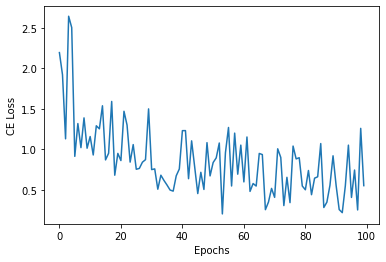

In [15]:
if num_epochs == len(train_losses):
    plt.plot(torch.Tensor(train_losses).detach().numpy())
    plt.xlabel('Epochs')
    plt.ylabel('CE Loss')
else:
    raise 'Training is not finished.'

In [16]:
# save the trained model
torch.save(model.state_dict(), 'CNN_CIFAR-10.pt')

## Evaluate the model

In [17]:
model2 = CNN(10)
model2.load_state_dict(torch.load('CNN_CIFAR-10.pt'))

def calc_accuracy(y_pred, y):
    which = y_pred.argmax(1)
    correct = (which == y).float().mean() * 100
    return correct

start_time = time.time()

test_losses = []
test_accuracy = []

model2.eval()

with torch.no_grad():
    for j, (img_list, lab_list) in enumerate(test_iterator):
        lab_pred = model2(img_list)

        loss = criterion(lab_pred, lab_list)
        test_losses.append(loss)

        acc = calc_accuracy(lab_pred, lab_list)
        test_accuracy.append(acc)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed


Duration: 2 seconds


Text(0, 0.5, 'CE Loss')

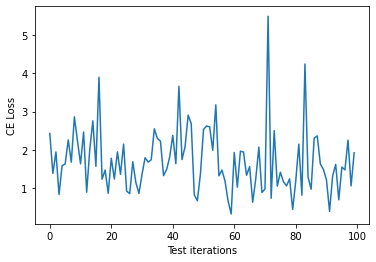

In [18]:
plt.plot(torch.Tensor(test_losses).detach().numpy())
plt.xlabel('Test iterations')
plt.ylabel('CE Loss')

Text(0, 0.5, 'Correct classifications (%)')

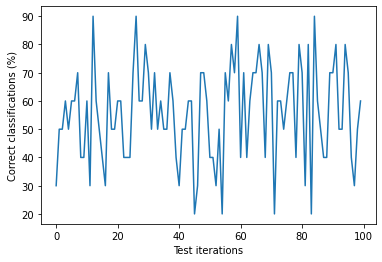

In [19]:
plt.plot(torch.Tensor(test_accuracy).detach().numpy())
plt.xlabel('Test iterations')
plt.ylabel('Correct classifications (%)')

Make the confusion matrix using all of the test data

In [20]:
# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    for X_test, y_test in test_load_all:
        test_pred_all = model(X_test.to(device))
        correct = (test_pred_all.argmax(1) == y_test.to(device))

test_pred_all = test_pred_all.cpu().detach().numpy()
correct = correct.cpu().detach().numpy()

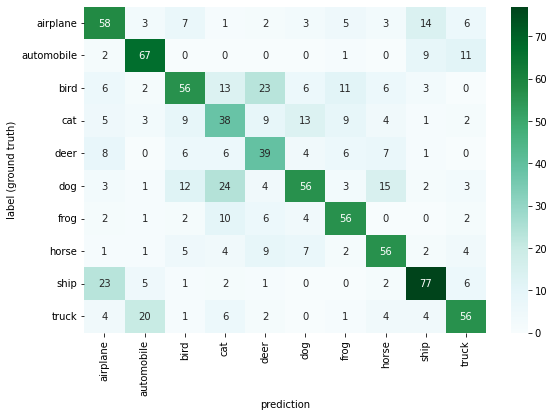

In [21]:
arr = confusion_matrix(test_pred_all.argmax(1), y_test.detach().numpy())

df_cm = pd.DataFrame(arr, [class_idx_to_names[i] for i in range(10)], [class_idx_to_names[i] for i in range(10)])
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()


## Examine the top misses

Top misses are defined as the instances that are missclassified but have high confidence in the classified result.

In [22]:
test_class_all  = test_pred_all.argmax(1).astype(int)
test_class_true = y_test.detach().numpy()
test_probs_all  = np.exp(np.max(test_pred_all, axis = 1))
top_misses      = np.argsort(test_probs_all * (1 - correct))[::-1]

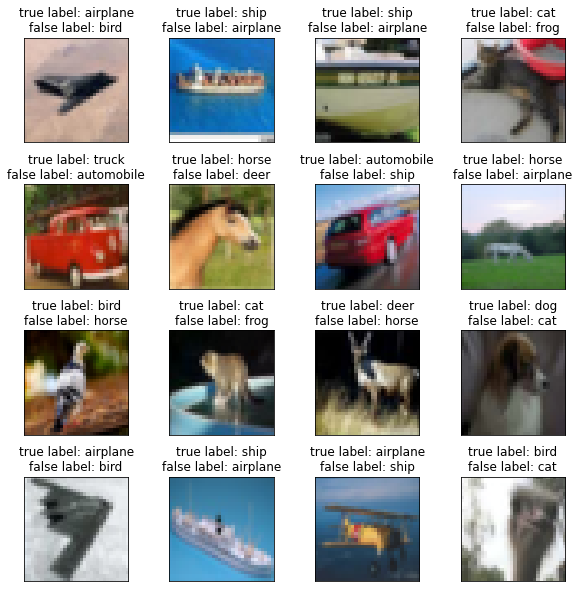

In [23]:
img_list = []
lab_list = []
for i in range(16):
    j = top_misses[i]
    img_list.append( (X_test[j] * stds.reshape(3,1,1) + means.reshape(3,1,1))  ) # re-normalize
    lab_list.append( f'true label: {class_idx_to_names[test_class_true[j]]}\nfalse label: {class_idx_to_names[test_class_all[j]]}' )
img_plotter(img_list, lab_list)
plt.subplots_adjust(hspace=0.4)

## Examine the trained filters

In [24]:
model.features # sequence of modules

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): ReLU()
)

In [25]:
filters = model.features[0].weight.data

In [26]:
filters.shape

torch.Size([6, 3, 5, 5])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


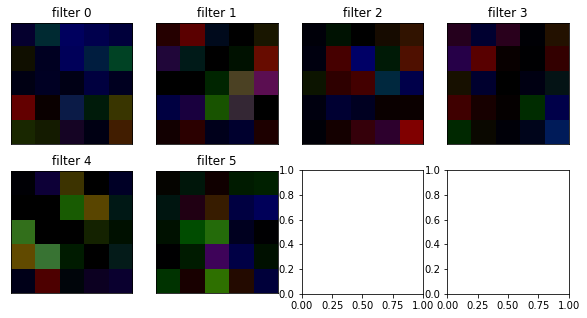

In [27]:
img_list = []
lab_list = []
for i in range(6):
    img_list.append( filters[i].cpu().detach() )
    lab_list.append( f'filter {i}' )
img_plotter(img_list, lab_list)

## Examine the filtered images

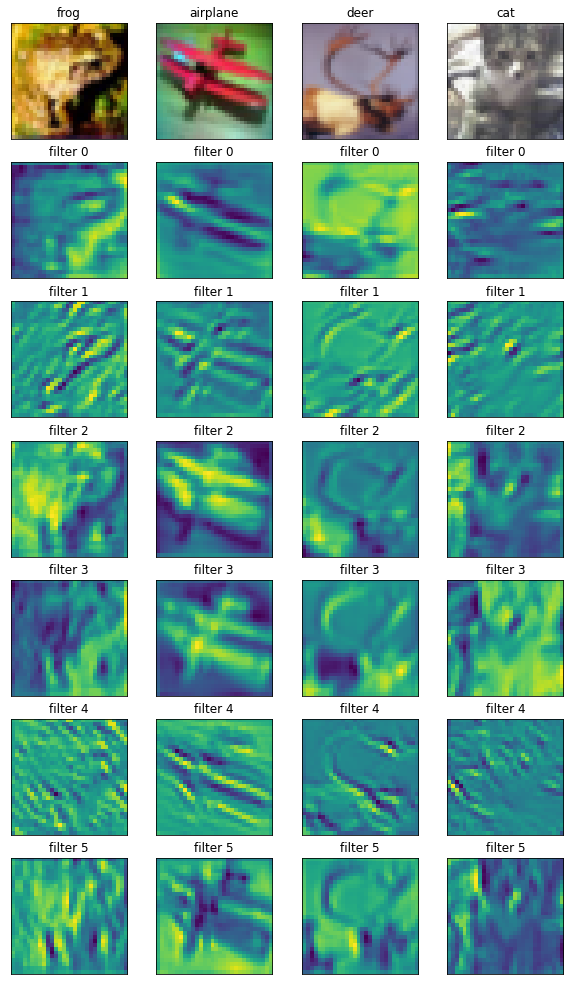

In [40]:
img_list = [None] * 28
lab_list = [None] * 28
for i in range(4):
    img_list[i] = X_test[i] * stds.reshape(-1,1,1) + means.reshape(-1,1,1)
    lab_list[i] = class_idx_to_names[test_class_true[i]]
    for j in range(6):
        img_list[(j+1)*4+i] = F.conv2d(X_test[i].unsqueeze(0), filters[j].cpu().unsqueeze(0), padding = 1).detach()[0,0,:,:]
        lab_list[(j+1)*4+i] = f'filter {j}'
img_plotter(img_list, lab_list)